## Modules needed

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, RandomOverSampler, SMOTE, SMOTEN, SMOTENC, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import pickle
import warnings
warnings.filterwarnings('ignore')

## Loading backed up data

In [2]:
churn_df_details = pickle.load(open('churn_df_details.pkl','rb'))

In [3]:
churn_df_details.keys()

dict_keys(['df', 'obj_cols', 'num_cols', 'significant_features', 'df_dummy', 'df_final', 'y'])

In [7]:
churn_df_details['df'].PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [14]:
int_features = ['12','One Year','Electronic check','Single Line','Fiber optic','OS']

In [23]:
np.squeeze([[0]]) == 1

False

In [18]:
[[int(int_features[0]), 1 if int_features[1] == 'One Year' else 0, 1 if int_features[1] == 'Two Year' else 0,
  1 if 'OS' in int_features else 0, 1 if 'TS' in int_features else 0, 1 if int_features[4] == 'Fiber optic' else 0,
  1 if int_features[2] == 'Electronic check' else 0, 1 if 'OB' in int_features else 0, 1 if 'SM' in int_features else 0,
  1 if int_features[4] == 'Not subscribed' else 0, 1 if 'ST' in int_features else 0, 1 if 'PB' in int_features else 0,
  1 if 'SC' in int_features else 0, 1 if int_features[3] == 'Not subscribed' else 0, 
  1 if int_features[3] == 'Multiple Lines' else 0]]

[[12, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

In [13]:
#print(churn_df_details['df_final'].columns)
print(churn_df_details['significant_features'])

['tenure', 'Contract_One year', 'Contract_Two year', 'OnlineSecurity_Yes', 'TechSupport_Yes', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'OnlineBackup_Yes', 'StreamingMovies_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'PaperlessBilling_Yes', 'SeniorCitizen_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes']


In [5]:
df = churn_df_details['df']
obj_cols = churn_df_details['obj_cols']
num_cols = churn_df_details['num_cols']

In [6]:
obj_cols.remove('Churn')

In [7]:
df_cat = df[obj_cols]
df_num = df[num_cols]
y = df[['Churn']].replace({'Yes':1,'No':0})

## Multicolinearity - Variance inflation factor

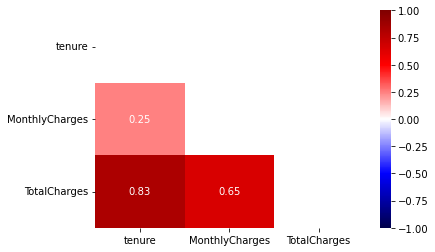

In [8]:
corre = df_num.corr()
sns.heatmap(corre,annot=True,fmt='.2f',cmap='seismic',vmin=-1,vmax=1,mask=np.triu(corre))
plt.show()

In [9]:
vif = pd.DataFrame({'Features':df_num.columns})
vif['vif'] = [variance_inflation_factor(df_num.values,i) for i in range(df_num.shape[1])]
cols = vif.sort_values(by='vif',ascending=False).head(2).Features
vif.sort_values(by='vif',ascending=False)

,Features,vif
2,TotalCharges,8.079181
0,tenure,6.332432
1,MonthlyCharges,3.361075


**Inference**
- There is no significant multicollinearity existing between the independent features as the VIF factor < 10

## Statistical test for numerical variables:

#### Shapiro_test

In [10]:
#Normality test(Shapiro):

#Ho : skew = 0 (Data is normal)
#Ha : skew = 0 (Data is not normal)

In [11]:
df_shapiro_num = pd.DataFrame(index=df_num.columns,columns=['W-stat1','pval1','W-stat2','pval2'])
for i in df_num.columns:
    group_1 = df_num[i][df['Churn'] == 'No']
    group_2 = df_num[i][df['Churn'] == 'Yes']
    w1,pval1 = stats.shapiro(group_1)
    w2,pval2 = stats.shapiro(group_2)
    df_shapiro_num.loc[i] = [w1,pval1,w2,pval2]

In [12]:
df_shapiro_num

,W-stat1,pval1,W-stat2,pval2
tenure,0.917704,0.0,0.819973,0.0
MonthlyCharges,0.912978,0.0,0.928404,0.0
TotalCharges,0.883559,0.0,0.778718,0.0


**From the Shapiro test**, we reject the null hypothesis

- Hence the features are not normally distributed

Since the assumption of th t-test is violated, we have to proceed with non parametric tests such as **Mann-whitney u test** to understand the significance of the variables

## Mann Whitney U test

### Hypothesis Framing

- Ho : The two samples have the same median
- Ha : The two samples have different median

In [13]:
df_mw = pd.DataFrame(index=df_num.columns,columns=['Ustat','pval'])
for i in df_num.columns:
    group_1 = df_num[i][df['Churn'] == 'No']
    group_2 = df_num[i][df['Churn'] == 'Yes']
    hstat,pval = stats.mannwhitneyu(group_1,group_2)
    df_mw.loc[i,'Ustat'] = hstat
    df_mw.loc[i,'pval'] = pval

In [14]:
df_mw

,Ustat,pval
tenure,7154668.0,0.0
MonthlyCharges,3663498.5,0.0
TotalCharges,6288982.0,0.0


**From the Mann Whitney U test**, we reject the null hypothesis

- All the features are statistically significant to have different medians

## Statistical test for categorical variables:

### Hypothesis Framing

- Ho : There is no relation between independent features and readmitted
- Ha : There is relation between independent features and readmitted

In [15]:
df_Chi2_contingency_cat = pd.DataFrame({'Features':obj_cols})
P_value = []
dof = []
for i in obj_cols:
    obs = pd.crosstab(df_cat[i],df['Churn'])
    chi_sq,p_val,ddof,exp = stats.chi2_contingency(obs)
    P_value.append(p_val)
    dof.append(ddof)
    
df_Chi2_contingency_cat['P_val'] = P_value

In [16]:
insig_cat = df_Chi2_contingency_cat[df_Chi2_contingency_cat['P_val'] > 0.05].sort_values(by='P_val',ascending=True)
sig_cat = df_Chi2_contingency_cat[df_Chi2_contingency_cat['P_val'] <= 0.05].sort_values(by='P_val',ascending=True)
print(len(obj_cols),len(insig_cat))

16 2


In [17]:
insig_cat

,Features,P_val
4,PhoneService,0.349924
0,gender,0.490488


**From the Chi-square contingency test**, features regarding PhoneService and Gender is found to have no relation with the Churn rate. Hence from further analysis, it can be excluded

## One hot encoding

In [18]:
df_cat_dummy = pd.get_dummies(df_cat[sig_cat.Features],drop_first=True)
df_sig = pd.concat(objs=[df_num,df_cat_dummy],axis=1)

## Transformation for Skewness

In [19]:
df_num.skew()

tenure            0.237731
MonthlyCharges   -0.222103
TotalCharges      0.961642
dtype: float64

<AxesSubplot:xlabel='TotalCharges', ylabel='Density'>

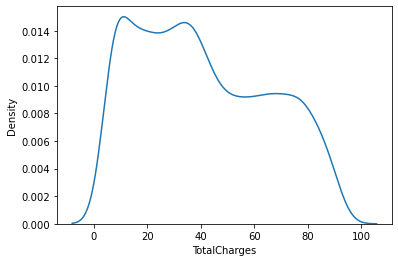

In [20]:
sns.kdeplot(np.sqrt(df_num.TotalCharges))

In [21]:
df_sig.TotalCharges = np.sqrt(df_num.TotalCharges)

In [22]:
df_sig[num_cols].skew()

tenure            0.237731
MonthlyCharges   -0.222103
TotalCharges      0.308926
dtype: float64

## Multicollinearity after encoding

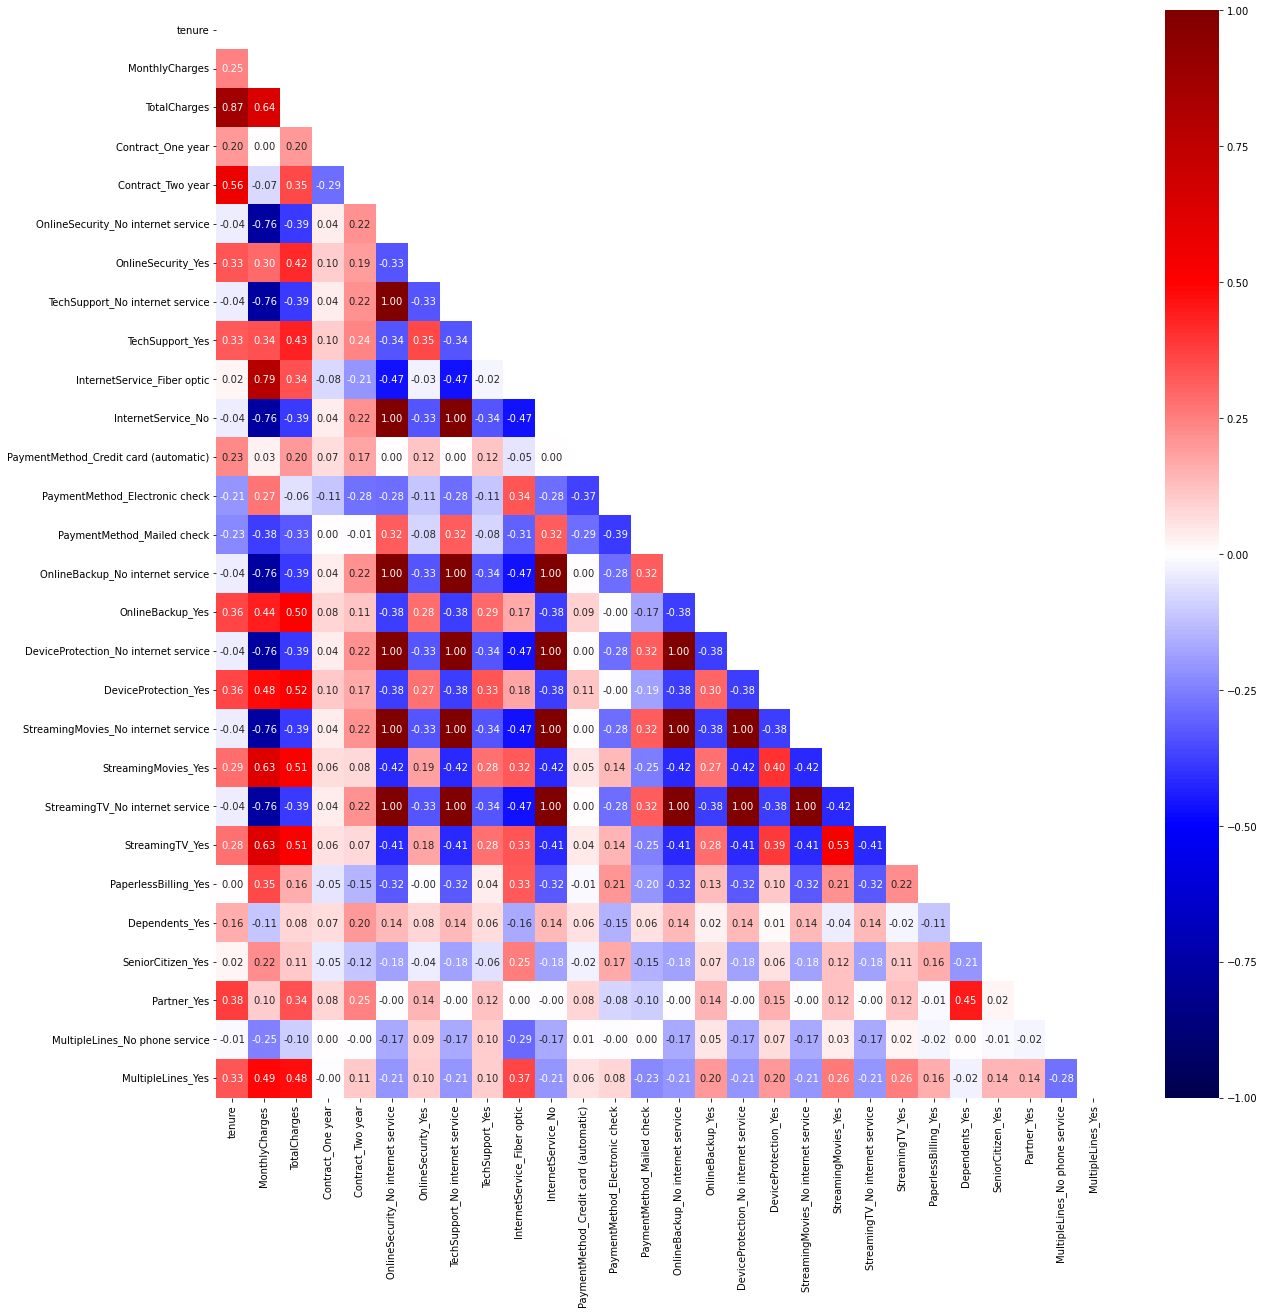

In [23]:
plt.figure(figsize=(20,20))
corre = df_sig.corr()
sns.heatmap(corre,annot=True,fmt='.2f',cmap='seismic',vmin=-1,vmax=1,mask=np.triu(corre))
plt.show()

In [24]:
df_sig_copy = df_sig.copy()
removed_columns = []
while True:
    vif = pd.DataFrame({'Features':df_sig_copy.columns})
    vif['vif'] = [variance_inflation_factor(df_sig_copy.values,i) for i in range(df_sig_copy.shape[1])]
    vif_max_value = vif['vif'].max()
    if vif_max_value > 10:
        removed_feature = vif.iloc[(vif['vif'].idxmax())]['Features']
        removed_columns.append([removed_feature,vif_max_value])
        df_sig_copy.drop(columns=removed_feature,inplace=True)
    else:
        break
cols = vif.sort_values(by='vif',ascending=False).head(2).Features
vif.sort_values(by='vif',ascending=False)

,Features,vif
0,tenure,7.600806
2,Contract_Two year,3.456841
5,InternetService_Fiber optic,3.158971
17,Partner_Yes,2.810796
14,PaperlessBilling_Yes,2.676755
11,StreamingMovies_Yes,2.668318
13,StreamingTV_Yes,2.639348
12,StreamingTV_No internet service,2.558868
19,MultipleLines_Yes,2.438051
10,DeviceProtection_Yes,2.241119


In [25]:
removed_columns

[['OnlineSecurity_No internet service', inf],
 ['TechSupport_No internet service', inf],
 ['InternetService_No', inf],
 ['OnlineBackup_No internet service', inf],
 ['DeviceProtection_No internet service', inf],
 ['StreamingMovies_No internet service', inf],
 ['TotalCharges', 89.77081915615346],
 ['MonthlyCharges', 38.328846187774175]]

In [26]:
df_final = df_sig[vif['Features'].values]

## Train test val splitting and Feature selection by Recursive Backward Elimination

In [27]:
## Splitting the dataset
xtrain_test, xval, ytrain_test, yval = train_test_split(df_final,y,train_size=0.8,random_state=10,stratify=y)
xtrain, xtest, ytrain, ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,random_state=10,stratify=ytrain_test)

#Feature Selection by Recursive Backward Elimination
cols = list(xtrain.columns)
print(len(cols))
pmax = 1
while (len(cols)>0):
    p= []
    X = xtrain[cols]
    Xc = sm.add_constant(X)
    model = sm.OLS(ytrain,Xc).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
significant_features_final = cols
print(len(significant_features_final))

20
15


In [28]:
print(significant_features_final)

['tenure', 'Contract_One year', 'Contract_Two year', 'OnlineSecurity_Yes', 'TechSupport_Yes', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'OnlineBackup_Yes', 'StreamingMovies_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'PaperlessBilling_Yes', 'SeniorCitizen_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes']


In [29]:
churn_df_details['significant_features'] = significant_features_final

## Base model

### 1) Logistic Regression

**The logistic regression method assumes that:**

- The outcome is a binary or dichotomous variable like yes vs no, positive vs negative, 1 vs 0
- There is a linear relationship between the logit of the outcome and each predictor variables. Recall that the logit function is logit(p) = log(p/(1-p)), where p is the probabilities of the outcome.
- There is no influential values (extreme values or outliers) in the continuous predictors
- There is no high intercorrelations (i.e. multicollinearity) among the predictors

In [30]:
Xc = sm.add_constant(xtrain[significant_features_final])
model_lr = sm.OLS(ytrain,Xc).fit()
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Churn   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     113.7
Date:                Sun, 02 Jan 2022   Prob (F-statistic):          8.49e-300
Time:                        12:44:26   Log-Likelihood:                -1983.2
No. Observations:                4500   AIC:                             3998.
Df Residuals:                    4484   BIC:                             4101.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.3659      0.018     19.991      0.000       0.330       0.402
tenure                             -0.0051      0.000    -13.960      0.000      -0.006      -0.004
Contract_One year                  -0.0950      0.017     -5.433      0.000      -0.129      -0.061
Contract_Two year                  -0.0545      0.021     -2.569      0.010      -0.096      -0.013
OnlineSecurity_Yes                 -0.0659      0.015     -4.443      0.000      -0.095      -0.037
TechSupport_Yes                    -0.0631      0.015     -4.183      0.000      -0.093      -0.034
InternetService_Fiber optic         0.1337      0.016      8.338      0.000       0.102       0.165
PaymentMethod_Electronic check      0.0775      0.014      5.691      0.000       0.051       0.104
OnlineBackup_Yes                   -0.0280      0.014     -2.005      0.045      -0.055      -0.001
StreamingMovies_Yes                 0.0324      0.015      2.211      0.027       0.004       0.061
StreamingTV_No internet service    -0.1289      0.022     -5.885      0.000      -0.172      -0.086
StreamingTV_Yes                     0.0310      0.015      2.117      0.034       0.002       0.060
PaperlessBilling_Yes                0.0513      0.013      4.086      0.000       0.027       0.076
SeniorCitizen_Yes                   0.0393      0.016      2.451      0.014       0.008       0.071
MultipleLines_No phone service      0.0673      0.022      3.040      0.002       0.024       0.111
MultipleLines_Yes                   0.0474      0.014      3.457      0.001       0.021       0.074
==============================================================================
Omnibus:                      275.770   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              259.954
Skew:                           0.532   Prob(JB):                     3.56e-57
Kurtosis:                       2.496   Cond. No.                         224.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation from Coefficients

In [31]:
lr_coefficients = ((np.exp(model_lr.params[1:].sort_values(ascending=False))-1)*100).reset_index()
lr_coefficients.columns = ['Features','RelativeRisk']
lr_coefficients

,Features,RelativeRisk
0,InternetService_Fiber optic,14.300363
1,PaymentMethod_Electronic check,8.059020
2,MultipleLines_No phone service,6.958158
3,PaperlessBilling_Yes,5.259121
4,MultipleLines_Yes,4.850065
5,SeniorCitizen_Yes,4.010462
6,StreamingMovies_Yes,3.288049
7,StreamingTV_Yes,3.146724
8,tenure,-0.510537
9,OnlineBackup_Yes,-2.758103


- The relative risk of churning is high for customers for the following features (adjusting for the others)
    1. SeniorCitizen : Yes
    2. No PhoneService
    3. PhoneService with Multiple Telephone lines
    4. InternetService with Fiber optic 
    5. Subscribed for premium Streaming services
    6. Payment method by Electronic check
    7. opted for PaperlessBilling
-----
- The relative risk of churning is less for customers for the features (adjusting for the others)
    1. As tenure increases
    2. not subscribed for InternetSerivce (subscribed for PhoneService)
    3. subscribed for InternetService along with one of the following premium services
        - OnlineBackup
        - OnlineSecurity
        - Premium TechSupport
    4. Contract is either One year or Two year

#### Interpretation from Intercept

In [32]:
intercept = model_lr.params.const
intercept_exp = np.exp(intercept)
intercept_exp/(1+intercept_exp)

0.5904571208744669

A particular customer profile which has the following features
1. Tenure - Zero (New customer)
2. Not a SeniorCitizen
3. Subscribed to PhoneService but does not have multiple telephone lines
4. Subscribed to InternetService by DSL but does not use the following premium services
    - OnlineSecurity
    - Premium TechSupport
    - Online Backup
    - StreamingTV
5. Contract - Month-to-month
6. Payment Method other than electronic check
7. Not subscribed to PaperlessBilling

has the churn probability of **59%**

#### Cooks distance and Model Performance

In [33]:
influence = model_lr.get_influence()
cooks = influence.cooks_distance
print('Max cooks distance :',pd.Series(cooks[0]).max())
ytrain_pred_lr = [0 if i < 0.5 else 1 for i in model_lr.predict(sm.add_constant(xtrain[significant_features_final]))]
ytest_pred_lr = [0 if i < 0.5 else 1 for i in model_lr.predict(sm.add_constant(xtest[significant_features_final]))]

Max cooks distance : 0.0027878467666645527


In [34]:
print('Logistic Regression Classification report (Training) :\n\n',classification_report(ytrain, ytrain_pred_lr))
print('Logistic Regression Classification report (Test) :\n\n',classification_report(ytest, ytest_pred_lr))

Logistic Regression Classification report (Training) :

               precision    recall  f1-score   support

           0       0.84      0.91      0.87      3304
           1       0.67      0.50      0.57      1196

    accuracy                           0.80      4500
   macro avg       0.75      0.71      0.72      4500
weighted avg       0.79      0.80      0.79      4500

Logistic Regression Classification report (Test) :

               precision    recall  f1-score   support

           0       0.85      0.91      0.88       826
           1       0.68      0.55      0.60       299

    accuracy                           0.81      1125
   macro avg       0.76      0.73      0.74      1125
weighted avg       0.80      0.81      0.80      1125



### 2) Bernoulli Naive Bayes 

In [35]:
model_bnb = BernoulliNB()
model_bnb.fit(xtrain[significant_features_final].drop(columns='tenure'), ytrain)
ytrain_pred_bnb = model_bnb.predict(xtrain[significant_features_final].drop(columns='tenure'))
ytest_pred_bnb = model_bnb.predict(xtest[significant_features_final].drop(columns='tenure'))

In [36]:
prob_no_churn = ytrain.value_counts()[0]/len(ytrain)
prob_churn = ytrain.value_counts()[1]/len(ytrain)

df_feature_prob_bnb = pd.DataFrame(np.exp(model_bnb.feature_log_prob_),columns=significant_features_final[1:],index=['no_churn','churn']).T
((df_feature_prob_bnb['churn']/df_feature_prob_bnb['no_churn']-1)*(prob_churn/prob_no_churn)).sort_values(ascending=False)

PaymentMethod_Electronic check     0.465427
InternetService_Fiber optic        0.350669
SeniorCitizen_Yes                  0.328354
PaperlessBilling_Yes               0.149137
StreamingMovies_Yes                0.077678
StreamingTV_Yes                    0.072046
MultipleLines_Yes                  0.039497
MultipleLines_No phone service    -0.002369
OnlineBackup_Yes                  -0.079022
TechSupport_Yes                   -0.176180
OnlineSecurity_Yes                -0.185649
Contract_One year                 -0.224947
StreamingTV_No internet service   -0.280373
Contract_Two year                 -0.333280
dtype: float64

- The relative risk of churning is high for customers for the following features u (adjusting for the others)
    1. SeniorCitizen : Yes
    2. PhoneService with Multiple Telephone lines
    3. InternetService with Fiber optic 
    4. Subscribed for premium Streaming services
    5. Payment method by Electronic check
    6. opted for PaperlessBilling
-----
- The relative risk of churning is less for customers for the features (adjusting for the others)
    1. No PhoneService
    2. As tenure increases
    3. not subscribed for InternetSerivce (subscribed for PhoneService)
    4. subscribed for InternetService along with one of the following premium services
        - OnlineBackup
        - OnlineSecurity
        - Premium TechSupport
    5. Contract is either One year or Two year

In [37]:
print('Bernoulli Naive Bayes Classification report (Training) :\n\n',classification_report(ytrain, ytrain_pred_bnb))
print('Bernoulli Naive Bayes Classification report (Test) :\n\n',classification_report(ytest, ytest_pred_bnb))

Bernoulli Naive Bayes Classification report (Training) :

               precision    recall  f1-score   support

           0       0.86      0.81      0.84      3304
           1       0.55      0.63      0.59      1196

    accuracy                           0.77      4500
   macro avg       0.71      0.72      0.71      4500
weighted avg       0.78      0.77      0.77      4500

Bernoulli Naive Bayes Classification report (Test) :

               precision    recall  f1-score   support

           0       0.87      0.82      0.84       826
           1       0.57      0.67      0.62       299

    accuracy                           0.78      1125
   macro avg       0.72      0.74      0.73      1125
weighted avg       0.79      0.78      0.78      1125



### 3) Decision Tree Classifier

In [38]:
model_dt = DecisionTreeClassifier(random_state=10)
model_dt.fit(xtrain[significant_features_final], ytrain)
y_train_pred_dt = model_dt.predict(xtrain[significant_features_final])
y_test_pred_dt = model_dt.predict(xtest[significant_features_final])

In [39]:
pd.DataFrame({'Features' : significant_features_final,'Feature_imp' : model_dt.feature_importances_})\
.sort_values(by='Feature_imp',ascending=False)

,Features,Feature_imp
0,tenure,0.426316
5,InternetService_Fiber optic,0.119964
7,OnlineBackup_Yes,0.050202
11,PaperlessBilling_Yes,0.049475
3,OnlineSecurity_Yes,0.047806
6,PaymentMethod_Electronic check,0.044289
14,MultipleLines_Yes,0.041296
8,StreamingMovies_Yes,0.038492
12,SeniorCitizen_Yes,0.038285
4,TechSupport_Yes,0.037355


In [40]:
print('Decision Tree Classification report (Training) :\n\n',classification_report(ytrain, y_train_pred_dt))
print('Decision Tree Classification report (Test) :\n\n',classification_report(ytest, y_test_pred_dt))

Decision Tree Classification report (Training) :

               precision    recall  f1-score   support

           0       0.96      0.99      0.97      3304
           1       0.96      0.88      0.92      1196

    accuracy                           0.96      4500
   macro avg       0.96      0.94      0.95      4500
weighted avg       0.96      0.96      0.96      4500

Decision Tree Classification report (Test) :

               precision    recall  f1-score   support

           0       0.82      0.83      0.83       826
           1       0.52      0.50      0.51       299

    accuracy                           0.74      1125
   macro avg       0.67      0.66      0.67      1125
weighted avg       0.74      0.74      0.74      1125



### 4) RandomForest Classifier

In [41]:
model_rf = RandomForestClassifier(random_state=10)
model_rf.fit(xtrain[significant_features_final], ytrain)

y_train_pred_rf = model_rf.predict(xtrain[significant_features_final])
y_test_pred_rf = model_rf.predict(xtest[significant_features_final])

In [42]:
print('Random Forest Classification report (Training) :\n\n',classification_report(ytrain, y_train_pred_rf))
print('Random Forest Classification report (Test) :\n\n',classification_report(ytest, y_test_pred_rf))

Random Forest Classification report (Training) :

               precision    recall  f1-score   support

           0       0.97      0.98      0.97      3304
           1       0.94      0.90      0.92      1196

    accuracy                           0.96      4500
   macro avg       0.95      0.94      0.95      4500
weighted avg       0.96      0.96      0.96      4500

Random Forest Classification report (Test) :

               precision    recall  f1-score   support

           0       0.83      0.87      0.85       826
           1       0.59      0.50      0.54       299

    accuracy                           0.77      1125
   macro avg       0.71      0.69      0.70      1125
weighted avg       0.76      0.77      0.77      1125



## Sampling Techniques for Class Imbalance

In [43]:
def train_pred_report(xtrain,ytrain,xtest,ytest,xval,yval,sampling):
    
    model = BernoulliNB()
    model.fit(xtrain,ytrain)
    
    ypred_train, yprob_train = model.predict(xtrain), model.predict_proba(xtrain)[:,1]
    ypred_test, yprob_test = model.predict(xtest), model.predict_proba(xtest)[:,1]
    ypred_val, yprob_val = model.predict(xval), model.predict_proba(xval)[:,1]
    
    temp_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                       'F_score_1','Accuracy','roc_auc'])
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytrain,ypred_train,labels=[0,1])
    acc, roc_auc = metrics.accuracy_score(ytrain,ypred_train), metrics.roc_auc_score(ytrain,yprob_train)
    temp_score.loc[str(sampling)+'_Train'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytest,ypred_test,labels=[0,1])
    acc, roc_auc = metrics.accuracy_score(ytest,ypred_test), metrics.roc_auc_score(ytest,yprob_test)
    temp_score.loc[str(sampling)+'_Test'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(yval,ypred_val,labels=[0,1])
    acc, roc_auc = metrics.accuracy_score(yval,ypred_val), metrics.roc_auc_score(yval,yprob_val)
    temp_score.loc[str(sampling)+'_Val'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    return temp_score

def bnb_model(x,y,k=5):
    xtrain_test, xval, ytrain_test, yval = train_test_split(x,y,train_size=0.8,random_state=10,stratify=y)
    xtrain, xtest, ytrain, ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,random_state=10,stratify=ytrain_test)

    df_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                     'F_score_1','Accuracy','roc_auc'])
    
    print('Without sampling techniques')
    score = train_pred_report(xtrain,ytrain,xtest,ytest,xval,yval,sampling=None)
    df_score = pd.concat(objs=[df_score,score])

    rus = RandomUnderSampler(random_state=7,replacement=True)
    xrus, yrus = rus.fit_resample(xtrain,ytrain)
    print('RandomUnderSampling')
    score = train_pred_report(xrus,yrus,xtest,ytest,xval,yval,sampling='RUS')
    df_score = pd.concat(objs=[df_score,score])
    
    nm = NearMiss(n_neighbors=k)
    xnm, ynm = nm.fit_resample(xtrain,ytrain)
    print('Near miss Undersampling')
    score = train_pred_report(xnm,ynm,xtest,ytest,xval,yval,sampling='NearMiss')
    df_score = pd.concat(objs=[df_score,score])

    ros = RandomOverSampler(random_state=7)
    xros, yros = ros.fit_resample(xtrain,ytrain)
    print('RandomOverSampling')
    score = train_pred_report(xros,yros,xtest,ytest,xval,yval,sampling='ROS')
    df_score = pd.concat(objs=[df_score,score])

    smt = SMOTE(random_state=7,k_neighbors=k)
    xsmt, ysmt = smt.fit_resample(xtrain,ytrain)
    print('SMOTE-Oversampling')
    score = train_pred_report(xsmt, ysmt,xtest,ytest,xval,yval,sampling='SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    bsmt = BorderlineSMOTE(random_state=7,k_neighbors=k)
    xbsmt, ybsmt = bsmt.fit_resample(xtrain,ytrain)
    print('Borderline-SMOTE')
    score = train_pred_report(xbsmt, ybsmt,xtest,ytest,xval,yval,sampling='BL-SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    asn = ADASYN(random_state=7,n_neighbors=k)
    xasn, yasn = asn.fit_resample(xtrain,ytrain)
    print('ADASYN-Oversampling')
    score = train_pred_report(xasn, yasn,xtest,ytest,xval,yval,sampling='ADASYN')
    df_score = pd.concat(objs=[df_score,score])

    print('Completed')
    
    a,b = list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,0]), list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,1])
    df_score.insert(0,'Sampling_Type',a)
    df_score.insert(1,'Set_Type',b)
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.3, df_score.Recall_1[df_score.Set_Type=='Train'], 0.2, label = 'Train')
    plt.bar(X_axis - 0.1, df_score.Recall_1[df_score.Set_Type=='Test'], 0.2, label = 'Test')
    plt.bar(X_axis + 0.1, df_score.Recall_1[df_score.Set_Type=='Val'], 0.2, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Recall for not admitted')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.3, df_score.Precision_1[df_score.Set_Type=='Train'], 0.2, label = 'Train')
    plt.bar(X_axis - 0.1, df_score.Precision_1[df_score.Set_Type=='Test'], 0.2, label = 'Test')
    plt.bar(X_axis + 0.1, df_score.Precision_1[df_score.Set_Type=='Val'], 0.2, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Precision for not admitted')
    plt.legend()
    plt.show()
    
    return df_score

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


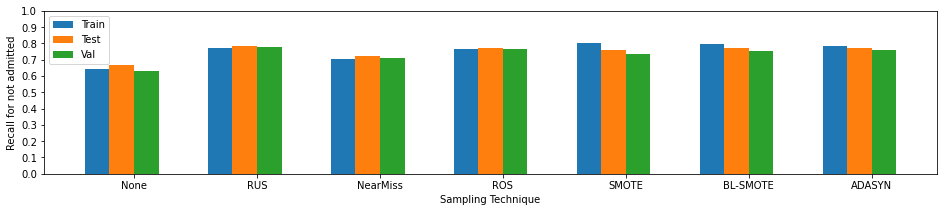

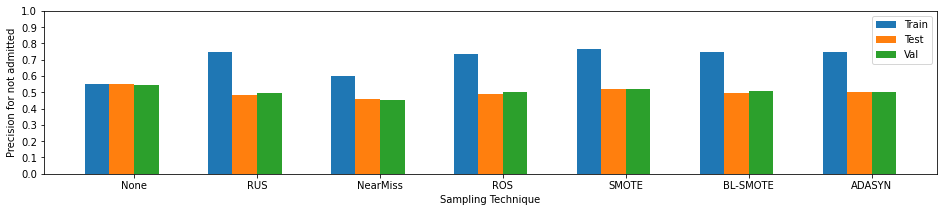

In [44]:
bnb_model_sampling_score = bnb_model(df_final,y,k=5)

#### Inference

- Recall had no impact after sampling
- Precision of the training set increased but the test and the validation set remained similar

In [45]:
bnb_model_sampling_score.to_csv('bnb_model_sampling_score.csv')

## Cross Validation Scores

In [46]:
def precision_positive(groundtruth,prediction):
    tn, fp, fn, tp = metrics.confusion_matrix(groundtruth,prediction).ravel()
    return (tp/(tp+fp))*100
        
def precision_negative(groundtruth,prediction):
    tn, fp, fn, tp = metrics.confusion_matrix(groundtruth,prediction).ravel()
    return (tn/(tn+fn))*100

def recall_positive(groundtruth,prediction):
    tn, fp, fn, tp = metrics.confusion_matrix(groundtruth,prediction).ravel()
    return (tp/(tp+fn))*100
    
def recall_negative(groundtruth,prediction):
    tn, fp, fn, tp = metrics.confusion_matrix(groundtruth,prediction).ravel()
    return (tn/(tn+fp))*100
        
precision_pos = metrics.make_scorer(precision_positive, greater_is_better=True)
precision_neg = metrics.make_scorer(precision_negative, greater_is_better=True)
recall_pos = metrics.make_scorer(recall_positive, greater_is_better=True)
recall_neg = metrics.make_scorer(recall_negative, greater_is_better=True)

In [47]:
def check_cvs(cvs):
    '''CVS Visualization'''
    sns.kdeplot(cvs)
    plt.show()
    
    '''Jarque bera test for checking normality'''
    jb_stat, jb_pval = stats.jarque_bera(cvs)
    jb_flag = 0
    if jb_pval >= 0.05:
        jb_flag = 1
        print('Scores are normally distributed')
    else:
        print('Scores are not normally distributed')
    
    '''Checking confidence interval'''
    mu_train, sig_train = np.mean(cvs), np.std(cvs,ddof=1)
    print('Mean score - {:.4f} %\nStd score - {:.4f} %'.format(mu_train,sig_train))
    if jb_flag == 1:
        low_limit, high_limit = stats.norm.interval(0.95,mu_train,sig_train)
        ranges = high_limit - low_limit
        print('95% confidence interval - {:.2f} % to {:.2f} % \nRange - {:.4f}'.format(low_limit, high_limit, ranges))

In [48]:
def compare_performance_with_without_SMOTE(cvs_with,cvs_without):
    '''Jarque bera test for checking normality'''
    jb_stat_with, jb_pval_with = stats.jarque_bera(cvs_with)
    jb_stat_without, jb_pval_without = stats.jarque_bera(cvs_without)
    jb_flag = []

    for pval in [jb_pval_with, jb_pval_without]:
        if pval >= 0.05:
            jb_flag.append(0)
        else:
            jb_flag.append(1)

    '''Test between 2 samples based on the JB test'''
    if sum(jb_flag) >= 1:
        norm_stat, norm_pval = stats.mannwhitneyu(cvs_with,cvs_without)
        method = 'Mann Whitney U test'
    else:
        norm_stat, norm_pval = stats.ttest_ind(cvs_with,cvs_without,random_state=10)
        method = '2 sample t-test'

    '''Checking pvalue returned and inference'''
    if norm_pval >= 0.05:
        print('CVS scores of the first and the second sets are statistically similar based on the {}.\
        \nStat - {} Pval - {}'.format(method, norm_stat, norm_pval))
    else:
        print('CVS scores of the first and the second sets are statistically different from each other based on the {}.\
        \nStat - {} Pval - {}'.format(method, norm_stat, norm_pval))

        if method == 'Mann Whitney U test':
            norm_stat_less, norm_pval_less = stats.mannwhitneyu(cvs_with,cvs_without,alternative='less')
        else:
            norm_stat_less, norm_pval_less = stats.ttest_ind(cvs_with,cvs_without,random_state=10,alternative='less')
            
        if norm_pval_less >= 0.05:
            print('\nCVS score of the second set is significantly lesser based on the {}.\
            \nStat - {} Pval - {}'.format(method, norm_stat_less, norm_pval_less))
        else:
            if method == 'Mann Whitney U test':
                norm_stat_greater, norm_pval_greater = stats.mannwhitneyu(cvs_with,cvs_without,alternative='greater')
            else:
                norm_stat_greater, norm_pval_greater = stats.ttest_ind(cvs_with,cvs_without,random_state=10,alternative='greater')
            
            if norm_pval_greater >= 0.05:
                print('\nCVS score of the second set is significantly greater based on the {}.\
                \nStat - {} Pval - {}'.format(method, norm_stat_greater, norm_pval_greater))
            else:
                print('\nDifferent.. Not possible')

In [49]:
model_bnb = BernoulliNB()

smt = SMOTE(random_state=10,k_neighbors=5)
model_bnb_smt = Pipeline([('sampling', smt),('classification', model_bnb)])

rus = RandomUnderSampler(random_state=7,replacement=True)
model_bnb_rus = Pipeline([('sampling', rus),('classification', model_bnb)])

kf = KFold(n_splits=10,shuffle=True,random_state=10)

### A) Recall for the class : churn = 1

#### 1) Without Sampling

In [50]:
cvs_recall = cross_val_score(model_bnb,df_final,y,scoring=recall_pos,cv=kf)

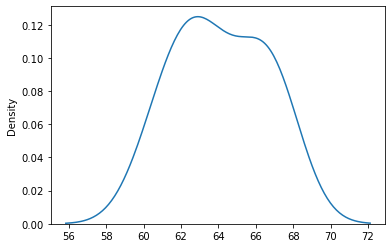

Scores are normally distributed
Mean score - 64.1003 %
Std score - 2.4314 %
95% confidence interval - 59.33 % to 68.87 % 
Range - 9.5309


In [51]:
check_cvs(cvs_recall)

### 2) SMOTE Sampling

In [52]:
cvs_recall_smt = cross_val_score(model_bnb_smt,df_final,y,scoring=recall_pos,cv=kf)

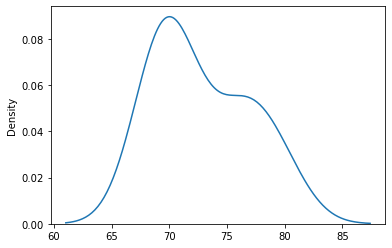

Scores are normally distributed
Mean score - 72.8486 %
Std score - 4.0728 %
95% confidence interval - 64.87 % to 80.83 % 
Range - 15.9652


In [53]:
check_cvs(cvs_recall_smt)

### 3) Random Under Sampling 

In [54]:
cvs_recall_rus = cross_val_score(model_bnb_rus,df_final,y,scoring=recall_pos,cv=kf)

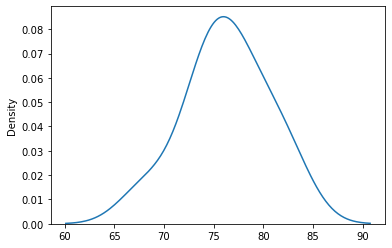

Scores are normally distributed
Mean score - 76.2841 %
Std score - 4.2378 %
95% confidence interval - 67.98 % to 84.59 % 
Range - 16.6117


In [55]:
check_cvs(cvs_recall_rus)

#### Comparisions based on recall

In [56]:
compare_performance_with_without_SMOTE(cvs_recall,cvs_recall_smt)

CVS scores of the first and the second sets are statistically different from each other based on the 2 sample t-test.        
Stat - -5.83224350607397 Pval - 1.5919050617173828e-05

CVS score of the second set is significantly greater based on the 2 sample t-test.                
Stat - -5.83224350607397 Pval - 0.9999920404746915


In [57]:
compare_performance_with_without_SMOTE(cvs_recall_rus,cvs_recall_smt)

CVS scores of the first and the second sets are statistically similar based on the 2 sample t-test.        
Stat - 1.8483899606099834 Pval - 0.08104324351027324


In [58]:
compare_performance_with_without_SMOTE(cvs_recall,cvs_recall_rus)

CVS scores of the first and the second sets are statistically different from each other based on the 2 sample t-test.        
Stat - -7.885953305695453 Pval - 3.0049560686875317e-07

CVS score of the second set is significantly greater based on the 2 sample t-test.                
Stat - -7.885953305695453 Pval - 0.9999998497521966


### B) Precision for the class : churn = 1

#### 1) Without Sampling

In [59]:
model_bnb = BernoulliNB()
kf = KFold(n_splits=10,shuffle=True,random_state=10)
cvs_precision = cross_val_score(model_bnb,df_final,y,scoring=precision_pos,cv=kf)

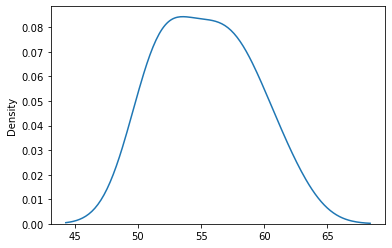

Scores are normally distributed
Mean score - 55.3696 %
Std score - 3.6007 %
95% confidence interval - 48.31 % to 62.43 % 
Range - 14.1146


In [60]:
check_cvs(cvs_precision)

### 2) SMOTE Sampling

In [61]:
model_bnb = BernoulliNB()
smt = SMOTE(random_state=10,k_neighbors=5)
model_bnb_smt = Pipeline([('sampling', smt),('classification', model_bnb)])

kf = KFold(n_splits=10,shuffle=True,random_state=10)
cvs_precision_smt = cross_val_score(model_bnb_smt,df_final,y,scoring=precision_pos,cv=kf)

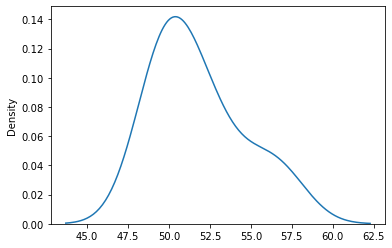

Scores are normally distributed
Mean score - 51.7883 %
Std score - 2.7454 %
95% confidence interval - 46.41 % to 57.17 % 
Range - 10.7620


In [62]:
check_cvs(cvs_precision_smt)

### 3) Random Under Sampling 

In [63]:
cvs_precision_rus = cross_val_score(model_bnb_rus,df_final,y,scoring=precision_pos,cv=kf)

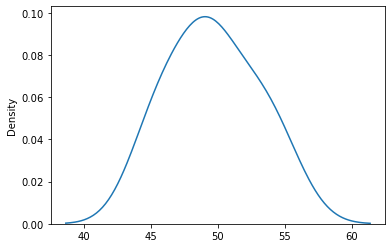

Scores are normally distributed
Mean score - 49.6117 %
Std score - 3.3216 %
95% confidence interval - 43.10 % to 56.12 % 
Range - 13.0204


In [64]:
check_cvs(cvs_precision_rus)

#### Comparisions based on recall

In [65]:
compare_performance_with_without_SMOTE(cvs_precision,cvs_precision_smt)

CVS scores of the first and the second sets are statistically different from each other based on the 2 sample t-test.        
Stat - 2.5011181835864464 Pval - 0.022256226633854893

CVS score of the second set is significantly lesser based on the 2 sample t-test.            
Stat - 2.5011181835864464 Pval - 0.9888718866830726


In [66]:
compare_performance_with_without_SMOTE(cvs_precision_rus,cvs_precision_smt)

CVS scores of the first and the second sets are statistically similar based on the 2 sample t-test.        
Stat - -1.5972203660861215 Pval - 0.12762285683172614


In [67]:
compare_performance_with_without_SMOTE(cvs_precision,cvs_precision_rus)

CVS scores of the first and the second sets are statistically different from each other based on the 2 sample t-test.        
Stat - 3.7168348087083536 Pval - 0.001578353225310111

CVS score of the second set is significantly lesser based on the 2 sample t-test.            
Stat - 3.7168348087083536 Pval - 0.999210823387345


#### Inference:

1. Based on the Cross validation scores, it is observed that the mean of precision and recall increased significantly after sampling.
2. The Standard Deviation of the precision has also reduced for the Model with SMOTE sampling technique
-----
- Hence choosing the SMOTE technique as the sampling technique for the final model

## Backing up details

In [68]:
churn_df_details['df_dummy'] = df_final
churn_df_details['df_final'] = df_final[significant_features_final]
churn_df_details['y'] = y

In [70]:
churn_df_details.keys()

dict_keys(['df', 'obj_cols', 'num_cols', 'significant_features', 'df_dummy', 'df_final', 'y'])

# Final Model

In [71]:
churn_df_details = pickle.load(open('churn_df_details.pkl','rb'))
X, Y = churn_df_details['df_final'], churn_df_details['y']

smt = SMOTE(random_state=7, k_neighbors=5)
xsmt, ysmt = smt.fit_resample(X, Y)

model_final = BernoulliNB()
model_final.fit(xsmt,ysmt)

with open('model_pkl', 'wb') as f:
    pickle.dump(model_final, f)
    f.close()